
<br>



# Hameltonian describing the system


## $\hat{H}=-t\sum\limits_{<i,j>}[c^\dagger_{i\sigma}c_{j\sigma}+h.c]+U\sum\limits_{i}n_{i\downarrow}n_{i\uparrow}+\frac{J_e}{2}\sum\limits_{i\in CoO_2}n_i$



### -  $t$ (<0) - hopping term 
### -  $U$ - hubbard U
### -  $J_e$ (<0) - electrostatic attraction between $Li^+$ and $CoO_2^-$

### need to add AFM term to force spin polarity between layers

In [1]:
from quspin.operators import hamiltonian 
from quspin.basis import spinful_fermion_basis_1d, tensor_basis
import numpy as np 
from quspin.basis import spinful_fermion_basis_1d
from itertools import combinations, cycle
from scipy import linalg as solve
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('ggplot')
#find min and max
def minmaxloc(num_list):
    return np.argmin(num_list), np.argmax(num_list)
def locate_min(a):
    smallest = min(a)
    return smallest, [index for index, element in enumerate(a) 
                      if smallest == element]
# plot energy bands
def plot_bands(energy):
    
    fig, ax = plt.subplots(1,2,figsize=(6,7))
    for i in np.real(energy):
        ax[0].axhline(y=i, xmin=.1, xmax=.5,alpha=.4)
    ax[1].hist(np.real(energy), bins=50, orientation="horizontal");
    ax[0].set_ylabel("Energies")
    ax[1].set_xlabel("DOS")
    plt.tight_layout()
    plt.show()

def plot_wavefunction(number):
    def normalize(x):
        norm1 = x / np.linalg.norm(x)
        return x
    #fig, ax = plt.subplots(2,1,figsize=(13,3))
    state=normalize(wave[number])
    s_up=np.zeros(L)
    s_down=np.zeros(L)
    for i in range(len(state)):
        s_up=np.add(s_up,np.multiply(base[i][0],state[i]**2))
        s_down=np.add(s_down,np.multiply(base[i][1],state[i]**2))


    fig, ax = plt.subplots(2,1,figsize=(10,8))    
    #plt.box(False)
    ax[0].axis('off')
    #ax[1].axis('off')
    x1=0
    x2=0
    x3=0
    layer="CoO_2"
    for i in range(L):
        ax[0].scatter(x1,.5,alpha=np.real(s_up[i]),s=3000*np.real(s_up[i]),c='red')
        ax[0].scatter(x2,1.5,alpha=np.real(s_down[i]),s=3000*np.real(s_down[i]),c='blue')
        ax[0].text(x1,.1,i+1,fontsize=15)
        ax[1].text(x3-.1,-.3,i+1,fontsize=15)
        ax[0].text(x1,1.86,layer,fontsize=12)
        x1=x1+.1
        x2=x2+.1
        x3=x3+1
        if layer=="CoO_2":
            layer="Li"
        else:
            layer="CoO_2"
    ax[0].axhline(2,.1,1)
    ax[0].axhline(.5,.1,1,linestyle=":",color="black",alpha=.3)
    ax[0].axhline(1.5,.1,1,linestyle=":",color="black",alpha=.3)
    ax[0].axhline(0,.1,1)
    plt.rcParams['axes.facecolor']='white'
    ax[1].bar(range(L),np.add(s_up,s_down), align='center')
    ax[1].set_ylim([0,2])
    labels = [item.get_text() for item in ax[1].get_xticklabels()]
    ax[1].axhline(1,0,1,color='black',alpha=.6)
    ax[1].axhline(2,0,1,color='black',alpha=.6)
    empty_string_labels = ['']*len(labels)
    ax[1].set_xticklabels(empty_string_labels)
    ax[1].set_ylabel("number of electrons")
    #ax[1].set_xlabel("Site")
    plt.ylim([0,2.1])    
    plt.tight_layout()
    plt.show()
# all possible basis set
def setup_basis(L=2,U=0,Ji=0,t=0,print_states=0):
    a=[]
    b=[]
    count=1
    test=[]
    N_up = L//2 + L % 2 # number of fermions with spin up
    N_down = L//2 # number of fermions with spin down
    for i in range(L+1):
        for j in range(L+1):
            if i+j==L:
                basis=spinful_fermion_basis_1d(L,Nf=(i,j))
                for values in str(basis).split("\n"):
                    temp=values.split("  ")
                    if len(temp)>2:
                        test.append(temp)
                        a.append(temp[-1])
                        b.append(count)
                        count+=1
    if print_states:
        for i in range(len(a)):
             print(b[i]," ",a[i])
    base=[]

    for i in a:
        pos=[]
        for j in i[1:-1].split(">|"):
            pos.append(list(map(float,(j.split(" ")))))
        base.append(pos)
    return base,a

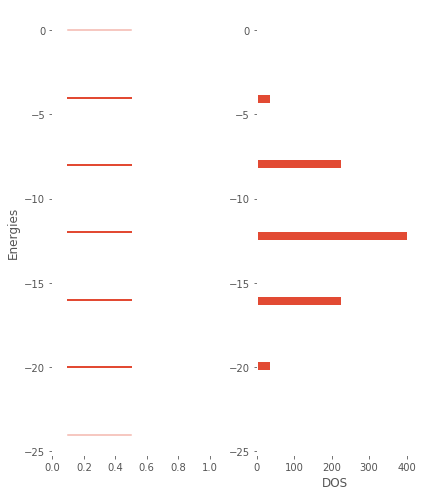

ValueError: RGBA values should be within 0-1 range

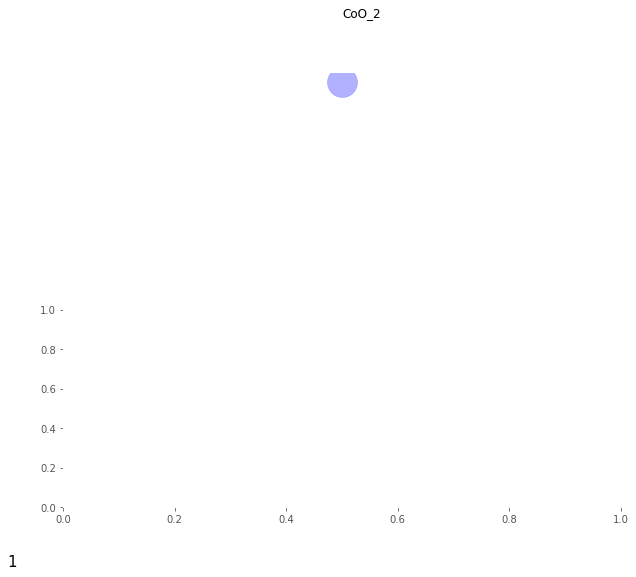

In [3]:
def ground_state(energy, wave):
    emin,emax=minmaxloc(energy)
    print("\n minimum energy = ",np.round(np.real(energy[emin]),3),"\n")
    temp=0
    string=[]
    for i in wave[emin]:
        if np.round(i,9)!=0:
            string.append(str(np.round(i,3))+"*"+base_str[temp])
        temp+=1
    print(" + ".join(string))

# adding on site coloumb 
def onsite(site):
    return np.count_nonzero(np.sum(site,axis=0)==2)

#+-+-... lattice ordering    
#
def ionic(site):
    return np.sum(np.sum(site,axis=0)[::2])
    
def swap(x1,x2):
    if (x1.count(1)!=x2.count(1)) or (x1.count(0)!=x2.count(0)):
        swaps=-10
        return swaps
    x1=[int(i) for i in x1]
    x2=[int(i) for i in x2]
    a1="".join(map(str,x1))
    a2="".join(map(str,x2))
    swaps = 0

    # 1)
    chars = {c: [] for c in a1}
    [chars[c].append(i) for i, c in enumerate(a1)]
    for k in chars.keys():
        chars[k] = cycle(chars[k])

    # 2)
    idxs = [next(chars[c]) for c in a2]

    # 3)
    for cmb in combinations(idxs, 2):
        if cmb[0] > cmb[1]:
            swaps += 1
    
    return swaps
# hopping term
def hopping(site1,site2):
    up_swap=swap(site1[0],site2[0])
    down_swap=swap(site1[1],site2[1])
    if up_swap+down_swap==1:
        return 1
    else:
        return 0

    
#add all the hameltonian together
def make_hameltonian(base):
    H=np.zeros((len(base),len(base)))
    for i in range(len(base)):
        H[i][i]+=U*onsite(base[i])
        H[i][i]+=Ji*ionic(base[i])
        
    for i in range(len(base)):
        for j in range(len(base)):
            H[i][j]+=t*hopping(base[i],base[j])
    return H

electron_per_layer=1
#for 2 layers
layers=3
L=layers*2   
U=.001
t=-.001
Ji=-4


base,base_str=setup_basis(L,U,Ji,t)
H=make_hameltonian(base)
energy, wave = solve.eig(H)
#ground_state(energy, wave)
#print(np.round(H,3))
emin,pos=locate_min(np.real(energy))
plot_bands(energy)
for i in pos:
    plot_wavefunction(i)
    

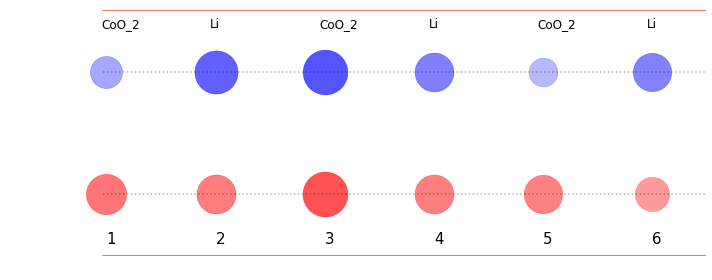

In [63]:
# number=4
#     def normalize(x):
#         norm1 = x / np.linalg.norm(x)
#         return x
#     #fig, ax = plt.subplots(2,1,figsize=(13,3))
#     state=normalize(wave[number])
#     s_up=np.zeros(L)
#     s_down=np.zeros(L)
#     for i in range(len(state)):
#         s_up=np.add(s_up,np.multiply(base[i][0],state[i]**2))
#         s_down=np.add(s_down,np.multiply(base[i][1],state[i]**2))


#     fig, ax = plt.subplots(2,1,figsize=(10,8),facecolor='white')    
#     #plt.box(False)
#     ax[0].axis('off')
#     #ax[1].axis('off')
#     #ax.axis('off')
#     x1=0
#     x2=0
#     layer="CoO_2"
#     for i in range(L):
#         ax[0].scatter(x1,.5,alpha=np.real(s_up[i]),s=3000*np.real(s_up[i]),c='red')
#         ax[0].scatter(x2,1.5,alpha=np.real(s_down[i]),s=3000*np.real(s_down[i]),c='blue')
#         ax[0].text(x1,.1,i+1,fontsize=15)
#         ax[0].text(x1,1.86,layer,fontsize=12)
#         x1=x1+.1
#         x2=x2+.1
#         if layer=="CoO_2":
#             layer="Li"
#         else:
#             layer="CoO_2"
#     ax[0].axhline(2,0,1)
#     ax[0].axhline(0,0,1)
#     count=0
#     raw_data = {'spin up': s_up, 'spin down': s_down}
#     import pandas as pd
#     df = pd.DataFrame(raw_data)
#     totals = [i+j for i,j in zip(df['spin up'], df['spin down'])]
#     greenBars = [i / j * 100 for i,j in zip(df['spin up'], totals)]
#     orangeBars = [i / j * 100 for i,j in zip(df['spin down'], totals)]
#     r = range(L)
#     names=[]

#     for i in range(int(L/2)):
#         names.append("CoO_2")
#         names.append("Li")
#     barWidth = 0.2

#     ax[1].bar(r, greenBars, color='red', edgecolor='white', width=barWidth)
#     plt.rcParams['axes.facecolor']='white'
#     ax[1].bar(r, orangeBars, bottom=greenBars, color='blue', edgecolor='white', width=barWidth)
#     plt.ylim([0,2])
#     ax[1].set_yticks([], [])
#     ax[1].set_ylabel("percentage of spin in each site")
#     ax[0].set_title("Many-body wave function contribution")
#     plt.xticks(r, names)

#     plt.tight_layout()
#     plt.show()


In [136]:
number=3
def normalize(x):
    norm1 = x / np.linalg.norm(x)
    return x
#fig, ax = plt.subplots(2,1,figsize=(13,3))
    state=normalize(wave[number])
    s_up=np.zeros(L)
    s_down=np.zeros(L)
    for i in range(len(state)):
        s_up=np.add(s_up,np.multiply(base[i][0],state[i]**2))
        s_down=np.add(s_down,np.multiply(base[i][1],state[i]**2))


    fig, ax = plt.subplots(2,1,figsize=(10,8))    
    #plt.box(False)
    ax[0].axis('off')
    #ax[1].axis('off')
    x1=0
    x2=0
    x3=0
    layer="CoO_2"
    for i in range(L):
        ax[0].scatter(x1,.5,alpha=np.real(s_up[i]),s=3000*np.real(s_up[i]),c='red')
        ax[0].scatter(x2,1.5,alpha=np.real(s_down[i]),s=3000*np.real(s_down[i]),c='blue')
        ax[0].text(x1,.1,i+1,fontsize=15)
        ax[1].text(x3-.1,-10,i+1,fontsize=15)
        ax[0].text(x1,1.86,layer,fontsize=12)
        x1=x1+.1
        x2=x2+.1
        x3=x3+1
        if layer=="CoO_2":
            layer="Li"
        else:
            layer="CoO_2"
    ax[0].axhline(2,.1,1)
    ax[0].axhline(.5,.1,1,linestyle=":",color="black",alpha=.3)
    ax[0].axhline(1.5,.1,1,linestyle=":",color="black",alpha=.3)
    ax[0].axhline(0,.1,1)
    plt.rcParams['axes.facecolor']='white'
    percent=np.add(s_up,s_down)
    percent = 100*np.true_divide(percent, percent.sum(axis=0, keepdims=True))
    ax[1].bar(range(L),percent, align='center')
    ax[1].set_ylim([0,2])
    labels = [item.get_text() for item in ax[1].get_xticklabels()]
    ax[1].axhline(100./L,0,1,color='black',alpha=.6)
    empty_string_labels = ['']*len(labels)
    ax[1].set_xticklabels(empty_string_labels)
    ax[1].set_ylabel("percentage of electrons")
    #ax[1].set_xlabel("Site")
    plt.ylim([0,100])    
    plt.tight_layout()
    plt.show()